In [81]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from imblearn.under_sampling import RandomUnderSampler
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata

# Descargar recursos de NLTK (si es la primera vez)
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\34659\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\34659\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\34659\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\34659\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [86]:
# Cargar los datos
data = pd.read_csv("reviews_cascos_gaming.csv",sep=';', encoding="utf-8")

In [87]:
lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()
snowball = SnowballStemmer('spanish')

def quitar_tildes(texto):
    return ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')
    
def limpiar_texto(texto):
    # Quitar tildes
    texto = quitar_tildes(texto)
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar signos de puntuación y caracteres especiales
    # texto = re.sub(r"[^a-zA-Z\s]", " ", texto)
    # Tokenizar palabras
    palabras = word_tokenize(texto)
    # Lematizar
    palabras = [lemmatizer.lemmatize(palabra) for palabra in palabras] 
    # Stemming
    # palabras = [porter.stem(palabra) for palabra in word_tokenize(texto)]
    # palabras = [snowball.stem(palabra) for palabra in word_tokenize(texto)]
    # Eliminar stopwords
    palabras = [palabra for palabra in palabras if palabra not in stopwords.words("spanish")]
    return " ".join(palabras)

def sin_limpiar_texto(texto):
    return texto

# Aplicar limpieza a la columna de reseñas
data["review"] = data["review"].apply(limpiar_texto)

In [88]:
#df.to_csv("reviews.csv", index=False, sep=';')
data

,review,stars
0,empezare resena explicando alguien busque grab...,1
1,increible llegado caja . parece decepcionante ...,1
2,recien compradoslos enchufas switch jack funci...,1
3,"hola , encienden luce hacer enciendan ? gracia...",1
4,hace 2 ano compre hijo almohadillas estan comp...,1
...,...,...
786,sonido alta calidad . comodos . materiales cal...,5
787,compre hijo encantado articulo . buena calidad...,5
788,buen producto . funciona genial,5
789,auriculare gaming perfectos sonido durabilidad...,5


In [89]:
# Cargar el dataset
# input_file = "reviews_prod_20_29.csv"
# data = pd.read_csv(input_file, sep=';', encoding="utf-8")

# Suponiendo que las reseñas están en la columna 'review'
reseñas = data['review'].astype(str).fillna("")

# Vectorización BoW
def bow(reseñas):
    vectorizer = CountVectorizer()
    return vectorizer.fit_transform(reseñas)

# Vectorizacion TIF
def tif(reseñas):
    vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english', max_features=5000)
    return vectorizer.fit_transform(reseñas)

X = bow(reseñas)
# X = tif(reseñas)
y = data['stars']

# **ENTRENAMIENTO DEL MODELO**

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=12)


def entrenar_modelo(XTrain,XTest,YTrain,YTest):
    clasificadores = [
        MultinomialNB(alpha = 2),
        SVC(random_state = 12),
        LogisticRegression(random_state=12, class_weight="balanced", C = 1),
        # DecisionTreeClassifier(criterion='entropy', random_state=12),  # Árbol de decisión base
        # BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy', random_state=12),
                         # n_estimators=15, random_state=12),  # Bagging
        # AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy', random_state=12),
                           # n_estimators=15, random_state=12,algorithm = 'SAMME'),  # Boosting
        # RandomForestClassifier(criterion='entropy', n_estimators=15, random_state=12)  # Random Forest
    ]
    nombres = ['Naive-Bayes','SVC','LogisticRegression','DecisionTree', 'Bagging', 'Boosting', 'RandomForest']
    for i, clasificador in enumerate(clasificadores):
        #Entrenar modelo
        clasificador.fit(XTrain, YTrain)
        #Realizar prediccion
        y_test_pred = clasificador.predict(XTest)
        #Evaluar modelo
        acc = round(accuracy_score(YTest, y_test_pred)*100,2)
        print("El accuracy del clasificador ",nombres[i]," es: ",acc)
    
    return acc

acc = entrenar_modelo(X_train,X_test,Y_train,Y_test)

El accuracy del clasificador  Naive-Bayes  es:  52.83
El accuracy del clasificador  SVC  es:  52.83
El accuracy del clasificador  LogisticRegression  es:  59.75


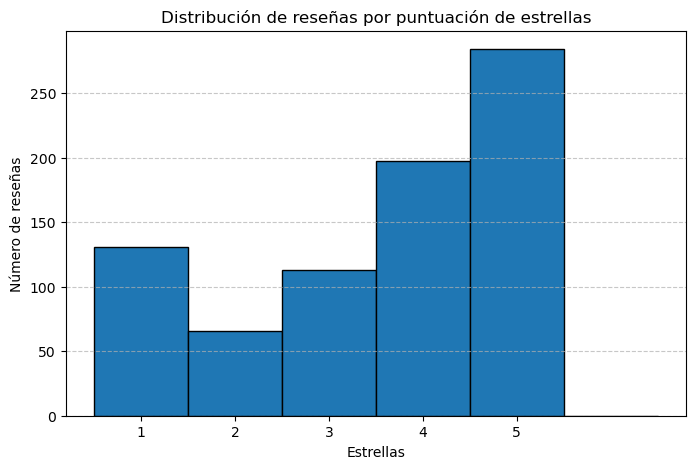

In [71]:
import matplotlib.pyplot as plt

# Crear histograma de la distribución de estrellas
plt.figure(figsize=(8, 5))
plt.hist(y, bins=range(1, 8), edgecolor='black', align='left')
plt.xticks(range(1, 6))  # Ajustar ticks a las puntuaciones de 1 a 5
plt.xlabel("Estrellas")
plt.ylabel("Número de reseñas")
plt.title("Distribución de reseñas por puntuación de estrellas")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
